# Volumetrics


This module that generates circuits on a graph which represents the QPU or QVM lattice. The basic idea is it will compute error rates of circuits as a function of depth and width.

The `width` of the circuit is the number of connected vertices on a particular subgraph.

The `depth` is defined in context-dependent way; to avoid confusion with circuit depth we may use the term 'repetitions'.

In [1]:
import random
import itertools
import networkx as nx
import numpy as np
import time

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer, get_benchmarker
from pyquil.gates import CNOT, CCNOT, Z, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest.benchmarking.volumetrics import *

## Get lattice

In [2]:
from pyquil import *
# if you want to run on a "real lattice"
#list_quantum_computers()
#perfect_qc = get_qc("Aspen-1-16Q-A", as_qvm=True, noisy=False)
#noisy_qc = get_qc("Aspen-1-16Q-A") #, as_qvm=True, noisy=True)

noisy_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=True)
perfect_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=False)

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


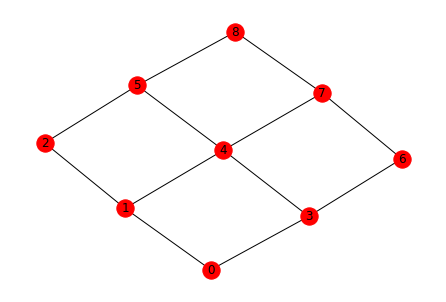

In [3]:
nx.draw(perfect_qc.qubit_topology(),with_labels=True)

In [4]:
G = perfect_qc.qubit_topology()

## Gate sets

### Classical

In [5]:
def two_q_id(qb1,qb2):
    prog = Program()
    prog +=I(qb1)
    prog +=I(qb2)
    return prog

one_c_gates = [X,I]
two_c_gates = [two_q_id, CNOT]
two_c_toffoli = two_c_gates + [CCNOT]

# x basis gates
from forest.benchmarking.classical_logic import CNOT_X_basis, CCNOT_X_basis
one_x_c_gates = [Z, I]
two_x_c_gates = [two_q_id, CNOT_X_basis]
two_x_c_toffoli = two_x_c_gates + [CCNOT_X_basis]
# if you want to do something in the X basis, add Hadamard layers appropriately; see below.

### Some quantum

In [6]:
one_q_gates = [X,Z,I]
two_q_gates = [two_q_id,CZ]

### Random Cliffords

We use a benchmarker for this. Typically we use the native gates from `get_rb_gateset` to implement each clifford.

In [7]:
from forest.benchmarking.randomized_benchmarking import get_rb_gateset

In [8]:
# my config has gone all cattywampus so i need to do this
bm = get_benchmarker()#endpoint='tcp://localhost:6000')

In [9]:
bm.client.endpoint

'tcp://127.0.0.1:5555'

## Get random gates on a graph

In [10]:
prog1 = random_single_qubit_gates(G, one_q_gates)
prog2 = random_two_qubit_gates(G, two_q_gates)
print(prog1+prog2)

I 0
I 1
I 2
I 3
I 4
X 5
I 6
I 7
Z 8
CZ 0 3
I 0
I 1
CZ 1 4
I 1
I 2
I 2
I 5
I 3
I 6
CZ 3 4
CZ 4 7
CZ 4 5
I 5
I 8
CZ 6 7
I 7
I 8



In [11]:
progy = random_single_qubit_cliffords(bm, G)
print(progy)

RZ(-pi/2) 0
RX(-pi) 0
RX(pi/2) 1
RZ(-pi/2) 1
RX(-pi/2) 2
RZ(pi/2) 2
RX(-pi) 3
RZ(pi/2) 4
RX(-pi/2) 4
RX(-pi/2) 5
RZ(-pi) 5
RX(-pi/2) 6
RZ(-pi) 6
RX(pi/2) 7
RZ(-pi) 7
RX(-pi/2) 8
RZ(pi/2) 8
RX(-pi/2) 8



## Make some circuit templates and sample programs from them


In [12]:
classical_1q_layer = get_rand_1q_template(one_c_gates)
print(classical_1q_layer.sample_program(G, repetitions=2, width=2))

I 4
I 5
I 4
X 5



In [13]:
classical_2q_layer = get_rand_2q_template(two_c_gates)
print(classical_2q_layer.sample_program(G, repetitions=2, width=2))

I 2
I 5
I 2
I 5



In [14]:
switch_basis_layer = get_switch_basis_x_z_template()
print(switch_basis_layer.sample_program(G, repetitions=1, width=4))

H 0
H 1
H 2
H 4



In [15]:
clifford_1q_layer = get_rand_1q_cliff_template(bm)
clifford_2q_layer = get_rand_2q_cliff_template(bm)
print(clifford_2q_layer.sample_program(G, repetitions=2, width=2))

RZ(-pi/2) 0
RX(-pi/2) 0
CZ 0 3
RZ(-pi/2) 0
RX(-pi) 0
CZ 0 3
RX(-pi/2) 3
RX(-pi/2) 0
RZ(-pi/2) 0



In [16]:
rand_perm_layer = get_rand_qubit_perm_template()
# sometimes this returns an empty program, i.e. no permutation
print(rand_perm_layer.sample_program(G, 1, qc=noisy_qc, width=3))

DEFGATE Perm102 AS PERMUTATION:
    0, 2, 1, 3, 4, 6, 5, 7
Perm102 1 2 4



In [17]:
rand_su4_layer = get_rand_su4_template()
print(rand_su4_layer.sample_program(G, 1, qc=noisy_qc, width=2))

DEFGATE LYR0_RSU4_2_5:
    -0.09969160814430622+0.0902156122395286i, -0.33709519811871885-0.048136235456428166i, 0.7703918235977348+0.48727367053674936i, -0.02107343025834974-0.18598165363223637i
    -0.4675035064037158+0.20523079122648438i, 0.038445207841979606-0.25078075097360014i, -0.05647270554583689+0.019169708299199825i, -0.7802899318958636+0.25008549090639387i
    -0.34089008290794076-0.7272853767121489i, 0.0027518127263039885-0.2069765795381728i, 0.2215611250339229-0.12193916055391807i, 0.20591837586243+0.4534778789801883i
    -0.0036986206424105654+0.27582562028872515i, 0.7923348800993039-0.38605604774942803i, 0.3168040759021317-0.034363504424924196i, 0.21335791201204357-0.002332725678737959i

LYR0_RSU4_2_5 2 5



## Compose templates

In [18]:
classical_1q_2q = classical_1q_layer + classical_2q_layer
print(classical_1q_2q.sample_program(G, repetitions=2, width=4))

I 0
X 3
X 4
I 6
I 0
I 3
I 3
I 6
I 3
I 4
I 0
I 3
I 4
X 6
CNOT 0 3
CNOT 3 6
CNOT 3 4



Classical Logic in X basis

In [19]:
logic_layers = get_rand_1q_template(one_x_c_gates) + get_rand_2q_template(two_x_c_gates)
classical_x_1q_2q = switch_basis_layer + logic_layers + switch_basis_layer
# here we demonstrate a simple use of a pattern. We want to do the basis switch at beginning and end 
# while doing the repetitions in between some variable number of times.
# The pattern says to do the 0 idx generator, do [1,2] idx generators n times, then finish with 3 idx generator
classical_x_1q_2q.pattern = [0, ([1, 2], 'n'), 3]
print(classical_x_1q_2q.sample_program(G, repetitions=3, width=2))
# note that the x basis CNOT(0, 1) is H(0) CZ(0, 1) H(0)

H 7
H 8
Z 7
Z 8
I 7
I 8
Z 7
I 8
I 7
I 8
I 7
Z 8
H 7
CZ 7 8
H 7
H 7
H 8



In [20]:
clifford_sandwich = clifford_1q_layer + clifford_2q_layer
clifford_sandwich.sequence_transforms.append(dagger_sequence)
prog = clifford_sandwich.sample_program(G, repetitions=3, width=2,  qc=noisy_qc)
print(prog)

# We can check that this is the identity by compiling it fully
print("This program compiles away to nothing: ")
print(noisy_qc.compiler.quil_to_native_quil(prog))

RZ(-pi/2) 1
RX(-pi) 1
RZ(-pi/2) 2
RX(-pi) 2
CZ 1 2
RX(-pi/2) 2
RZ(-pi/2) 2
RZ(-pi/2) 1
RX(-pi) 1
RZ(-pi/2) 1
RX(-pi/2) 1
RZ(-pi) 2
RX(-pi) 2
CZ 1 2
RZ(pi/2) 2
RX(pi/2) 2
RX(-pi/2) 1
CZ 1 2
RX(-pi/2) 2
RX(-pi/2) 1
CZ 1 2
RX(-pi/2) 1
RX(pi/2) 1
RZ(pi/2) 1
RX(-pi/2) 1
RX(-pi/2) 2
RZ(pi/2) 2
RX(-pi/2) 2
RX(pi/2) 2
RX(pi/2) 1
CZ 1 2
RX(pi/2) 2
RX(-pi/2) 1
CZ 1 2
RZ(-pi/2) 2
RZ(-pi/2) 1
DAGGER RZ(-pi/2) 1
DAGGER RZ(-pi/2) 2
DAGGER CZ 1 2
DAGGER RX(-pi/2) 1
DAGGER RX(pi/2) 2
DAGGER CZ 1 2
DAGGER RX(pi/2) 1
DAGGER RX(pi/2) 2
DAGGER RX(-pi/2) 2
DAGGER RZ(pi/2) 2
DAGGER RX(-pi/2) 2
DAGGER RX(-pi/2) 1
DAGGER RZ(pi/2) 1
DAGGER RX(pi/2) 1
DAGGER RX(-pi/2) 1
DAGGER CZ 1 2
DAGGER RX(-pi/2) 1
DAGGER RX(-pi/2) 2
DAGGER CZ 1 2
DAGGER RX(-pi/2) 1
DAGGER RX(pi/2) 2
DAGGER RZ(pi/2) 2
DAGGER CZ 1 2
DAGGER RX(-pi) 2
DAGGER RZ(-pi) 2
DAGGER RX(-pi/2) 1
DAGGER RZ(-pi/2) 1
DAGGER RX(-pi) 1
DAGGER RZ(-pi/2) 1
DAGGER RZ(-pi/2) 2
DAGGER RX(-pi/2) 2
DAGGER CZ 1 2
DAGGER RX(-pi) 2
DAGGER RZ(-pi/2) 2
DAGGER RX(-pi) 1

### Quantum Volume

In [21]:
qv_template = rand_su4_layer
# we want to compile the output sequences with graph-restricted compilation.
qv_template.sequence_transforms.append(compile_merged_sequence)
qv_prog = qv_template.sample_program(G, repetitions=2, qc=noisy_qc, width=4)
print(qv_prog)

RZ(-0.6633765634144329) 0
RX(pi/2) 0
RZ(2.1992567304350827) 0
RX(-pi/2) 0
RZ(1.213273479007638) 0
RZ(-2.1790140703661987) 1
RX(pi/2) 1
RZ(1.3833680725337012) 1
RX(-pi/2) 1
RZ(-1.5430363103535998) 1
CZ 1 0
RZ(pi/2) 0
RX(pi/2) 0
RZ(2.1382446014645566) 0
RX(-pi/2) 0
RZ(-pi/2) 1
RX(-pi/2) 1
CZ 1 0
RX(pi/2) 0
RZ(-1.6745691134157568) 0
RX(-pi/2) 0
RZ(1.8121261481912123) 1
RX(pi/2) 1
CZ 1 0
RZ(1.6380912332362045) 3
RX(pi/2) 3
RZ(1.2911009982026904) 3
RX(-pi/2) 3
RZ(2.905707049360048) 3
RZ(-0.3198967078677877) 0
RX(pi/2) 0
RZ(1.9993474339045234) 0
RX(-pi/2) 0
RZ(-2.045982310794382) 0
CZ 0 3
RZ(-pi/2) 0
RX(-pi/2) 0
RZ(pi/2) 3
RX(pi/2) 3
CZ 3 0
RZ(pi) 0
RX(pi/2) 0
RX(-pi/2) 3
CZ 0 3
RZ(-1.7211797008449619) 1
RX(-pi/2) 1
RZ(1.1291752835794742) 1
RX(-pi/2) 1
RZ(-0.9663730999073499) 2
RX(pi/2) 2
RZ(1.8104685056998722) 2
RX(-pi/2) 2
RZ(-1.1562967037020901) 2
CZ 1 2
RZ(-2.2067063329930843) 1
RX(-pi/2) 1
RZ(pi/2) 2
RX(pi/2) 2
CZ 2 1
RZ(pi) 1
RX(pi/2) 1
RX(-pi/2) 2
CZ 1 2
RZ(-1.7823332810518906) 0
RX(p

## Run quantum volume for one width and depth

1. Generate the programs
2. Determine the heavy outputs
3. Collect experimental data

In [66]:
start_time = time.time()
from pyquil.numpy_simulator import NumpyWavefunctionSimulator
wfn_sim = NumpyWavefunctionSimulator(9)
d = 2
qv_progs = generate_volumetric_program_array(perfect_qc, qv_template, 
                                             widths=[d], depths=[d], num_circuit_samples=200)
heavy_outputs = collect_heavy_outputs(wfn_sim, qv_progs)
experimental_data = acquire_volumetric_data(perfect_qc, qv_progs)

In [67]:
qvol_success_probs = get_success_probabilities(experimental_data, heavy_outputs)
print(qvol_success_probs)
print(np.average(qvol_success_probs[d][d]))

{2: {2: [0.6720000000000005, 0.8240000000000006, 0.9260000000000007, 0.8420000000000006, 0.8780000000000007, 0.6560000000000005, 0.5840000000000004, 0.8820000000000007, 0.8220000000000006, 0.8620000000000007, 0.8140000000000006, 0.7160000000000005, 0.8860000000000007, 0.7420000000000005, 0.6640000000000005, 0.8240000000000006, 0.6520000000000005, 0.5800000000000004, 0.7420000000000005, 0.6680000000000005, 0.9320000000000007, 0.8100000000000006, 0.6600000000000005, 0.9280000000000007, 0.6720000000000005, 0.6020000000000004, 0.7580000000000006, 0.7900000000000006, 0.8220000000000006, 0.9260000000000007, 0.6420000000000005, 0.7320000000000005, 0.7480000000000006, 0.9740000000000008, 0.8020000000000006, 0.7740000000000006, 0.7800000000000006, 0.9220000000000007, 0.7720000000000006, 0.8020000000000006, 0.7800000000000006, 0.7340000000000005, 0.8900000000000007, 0.8540000000000006, 0.7160000000000005, 0.8020000000000006, 0.7660000000000006, 0.8700000000000007, 0.7140000000000005, 0.880000000

In [68]:
qvol_successes = determine_successes(qvol_success_probs, 500)
print(qvol_successes)
end_time = time.time()
print(end_time - start_time)
print(determine_prob_success_lower_bounds(qvol_success_probs, 500))

{2: {2: True}}
35.48560094833374
{2: {2: 0.7382941716386486}}


## Acquire data for ranges of (width, depth)

In [25]:
widths = [2, 3, 4, 5]
depths = [2, 3, 4, 5, 10]
ckt = classical_1q_2q
prog_array = generate_volumetric_program_array(noisy_qc, ckt, widths, depths, num_circuit_samples=20)
print(prog_array)

{2: {2: [<pyquil.quil.Program object at 0x7f7772ea7748>, <pyquil.quil.Program object at 0x7f7772ea7da0>, <pyquil.quil.Program object at 0x7f7772cbc358>, <pyquil.quil.Program object at 0x7f7772b7c5f8>, <pyquil.quil.Program object at 0x7f7772cbc898>, <pyquil.quil.Program object at 0x7f7772cbcdd8>, <pyquil.quil.Program object at 0x7f7772ca6cf8>, <pyquil.quil.Program object at 0x7f7772ca6240>, <pyquil.quil.Program object at 0x7f7772ca69e8>, <pyquil.quil.Program object at 0x7f7772cbb3c8>, <pyquil.quil.Program object at 0x7f7772cbb908>, <pyquil.quil.Program object at 0x7f7772ca6ba8>, <pyquil.quil.Program object at 0x7f7772cbce10>, <pyquil.quil.Program object at 0x7f7772cbbc88>, <pyquil.quil.Program object at 0x7f77781e7240>, <pyquil.quil.Program object at 0x7f77781e7748>, <pyquil.quil.Program object at 0x7f77781e7c50>, <pyquil.quil.Program object at 0x7f77781e11d0>, <pyquil.quil.Program object at 0x7f77781e1710>, <pyquil.quil.Program object at 0x7f77781e1c50>], 3: [<pyquil.quil.Program objec

In [26]:
num_shots = 500
noisy_results = acquire_volumetric_data(noisy_qc, prog_array, num_shots)

In [27]:
ideal_results = acquire_volumetric_data(perfect_qc, prog_array, num_shots=1)
print(ideal_results)

{2: {2: [array([[1, 0]]), array([[1, 1]]), array([[1, 0]]), array([[1, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 0]]), array([[0, 1]]), array([[1, 0]]), array([[0, 1]]), array([[0, 1]]), array([[1, 0]]), array([[0, 1]]), array([[0, 1]]), array([[1, 0]]), array([[0, 1]]), array([[0, 0]]), array([[1, 1]]), array([[1, 1]]), array([[1, 0]])], 3: [array([[0, 0]]), array([[1, 1]]), array([[0, 1]]), array([[0, 1]]), array([[0, 1]]), array([[1, 0]]), array([[1, 1]]), array([[0, 0]]), array([[0, 0]]), array([[1, 1]]), array([[1, 1]]), array([[1, 1]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[0, 1]]), array([[0, 0]]), array([[1, 1]]), array([[1, 0]]), array([[1, 0]])], 4: [array([[1, 1]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[1, 0]]), array([[0, 1]]), array([[1, 0]]), array([[0, 0]]), array([[0, 0]]), array([[0, 0]]), array([[1, 1]]), array([[0, 0]]), array([[1, 0]]), array([[0, 1]]), array([[0, 0]]), array([[1, 0]]), array([[1, 0]]), array([[0, 1

In [28]:
err_hamm_distrs = get_error_hamming_weight_distributions(noisy_results, ideal_results)
print(err_hamm_distrs)

{2: {2: [array([0.848, 0.15 , 0.002]), array([0.82, 0.17, 0.01]), array([0.884, 0.116, 0.   ]), array([0.878, 0.118, 0.004]), array([0.892, 0.104, 0.004]), array([0.9, 0.1, 0. ]), array([0.9  , 0.098, 0.002]), array([0.872, 0.126, 0.002]), array([0.902, 0.098, 0.   ]), array([0.872, 0.116, 0.012]), array([0.906, 0.092, 0.002]), array([0.888, 0.108, 0.004]), array([0.898, 0.102, 0.   ]), array([0.916, 0.08 , 0.004]), array([0.898, 0.1  , 0.002]), array([0.898, 0.1  , 0.002]), array([0.938, 0.062, 0.   ]), array([0.814, 0.172, 0.014]), array([0.836, 0.156, 0.008]), array([0.888, 0.11 , 0.002])], 3: [array([0.948, 0.05 , 0.002]), array([0.828, 0.156, 0.016]), array([0.89 , 0.108, 0.002]), array([0.888, 0.11 , 0.002]), array([0.882, 0.118, 0.   ]), array([0.888, 0.106, 0.006]), array([0.826, 0.168, 0.006]), array([0.94, 0.06, 0.  ]), array([0.946, 0.052, 0.002]), array([0.814, 0.176, 0.01 ]), array([0.822, 0.16 , 0.018]), array([0.802, 0.186, 0.012]), array([0.832, 0.164, 0.004]), array([0

In [29]:
avg_err_hamm_distrs = average_distributions(err_hamm_distrs)
print(avg_err_hamm_distrs)

{2: {2: array([0.8824, 0.1139, 0.0037]), 3: array([0.8761, 0.1188, 0.0051]), 4: array([0.8923, 0.1034, 0.0043]), 5: array([0.8821, 0.1147, 0.0032]), 10: array([0.8854, 0.1093, 0.0053])}, 3: {2: array([8.329e-01, 1.566e-01, 9.800e-03, 7.000e-04]), 3: array([8.172e-01, 1.698e-01, 1.250e-02, 5.000e-04]), 4: array([0.8408, 0.1487, 0.0093, 0.0012]), 5: array([8.302e-01, 1.577e-01, 1.160e-02, 5.000e-04]), 10: array([0.8265, 0.1525, 0.0194, 0.0016])}, 4: {2: array([7.818e-01, 1.969e-01, 2.040e-02, 7.000e-04, 2.000e-04]), 3: array([0.7962, 0.1834, 0.0192, 0.0012, 0.    ]), 4: array([7.868e-01, 1.910e-01, 2.000e-02, 1.800e-03, 4.000e-04]), 5: array([7.691e-01, 2.042e-01, 2.460e-02, 1.900e-03, 2.000e-04]), 10: array([0.7377, 0.2199, 0.0345, 0.0068, 0.0011])}, 5: {2: array([7.399e-01, 2.293e-01, 2.730e-02, 3.000e-03, 5.000e-04, 0.000e+00]), 3: array([7.308e-01, 2.334e-01, 3.220e-02, 3.200e-03, 4.000e-04, 0.000e+00]), 4: array([7.299e-01, 2.288e-01, 3.440e-02, 5.500e-03, 1.000e-03, 4.000e-04]), 5:

## Plot a particular depth and width

In [30]:
w = 3 # width
d = 4 # depth

avg_distr = avg_err_hamm_distrs[3][4]

# rand data
rand_distr = get_random_hamming_wt_distr(w)

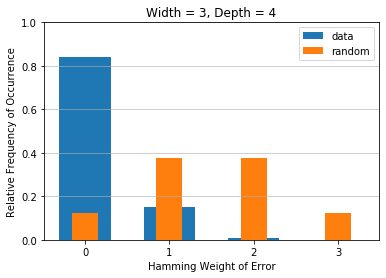

In [31]:
x_labels = np.arange(0, len(avg_distr))
plt.bar(x_labels, avg_distr, width=0.61, align='center')
plt.bar(x_labels, rand_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurrence')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title(f'Width = {w}, Depth = {d}')
plt.show()

Using our helper function

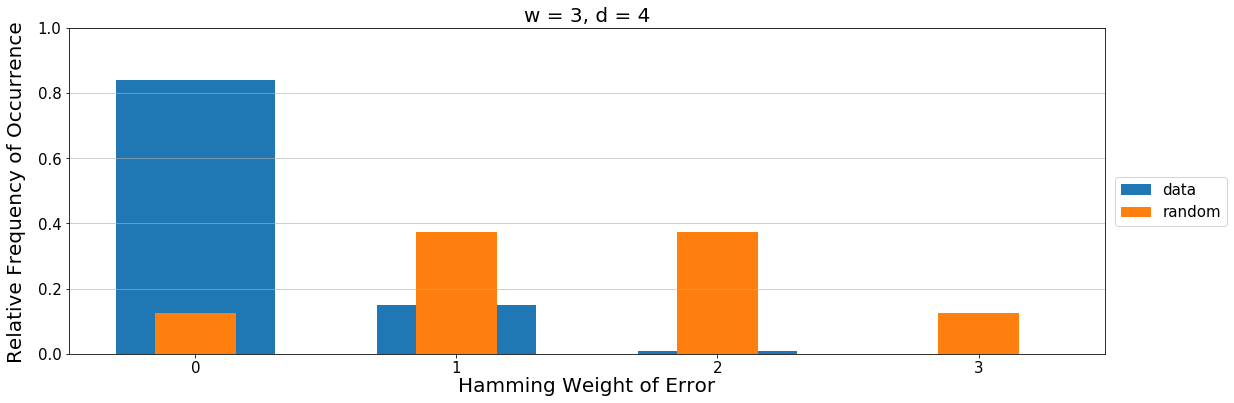

In [32]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=[w], depths=[d], plot_rand_distr=True)

### For a particular width, plot all depths

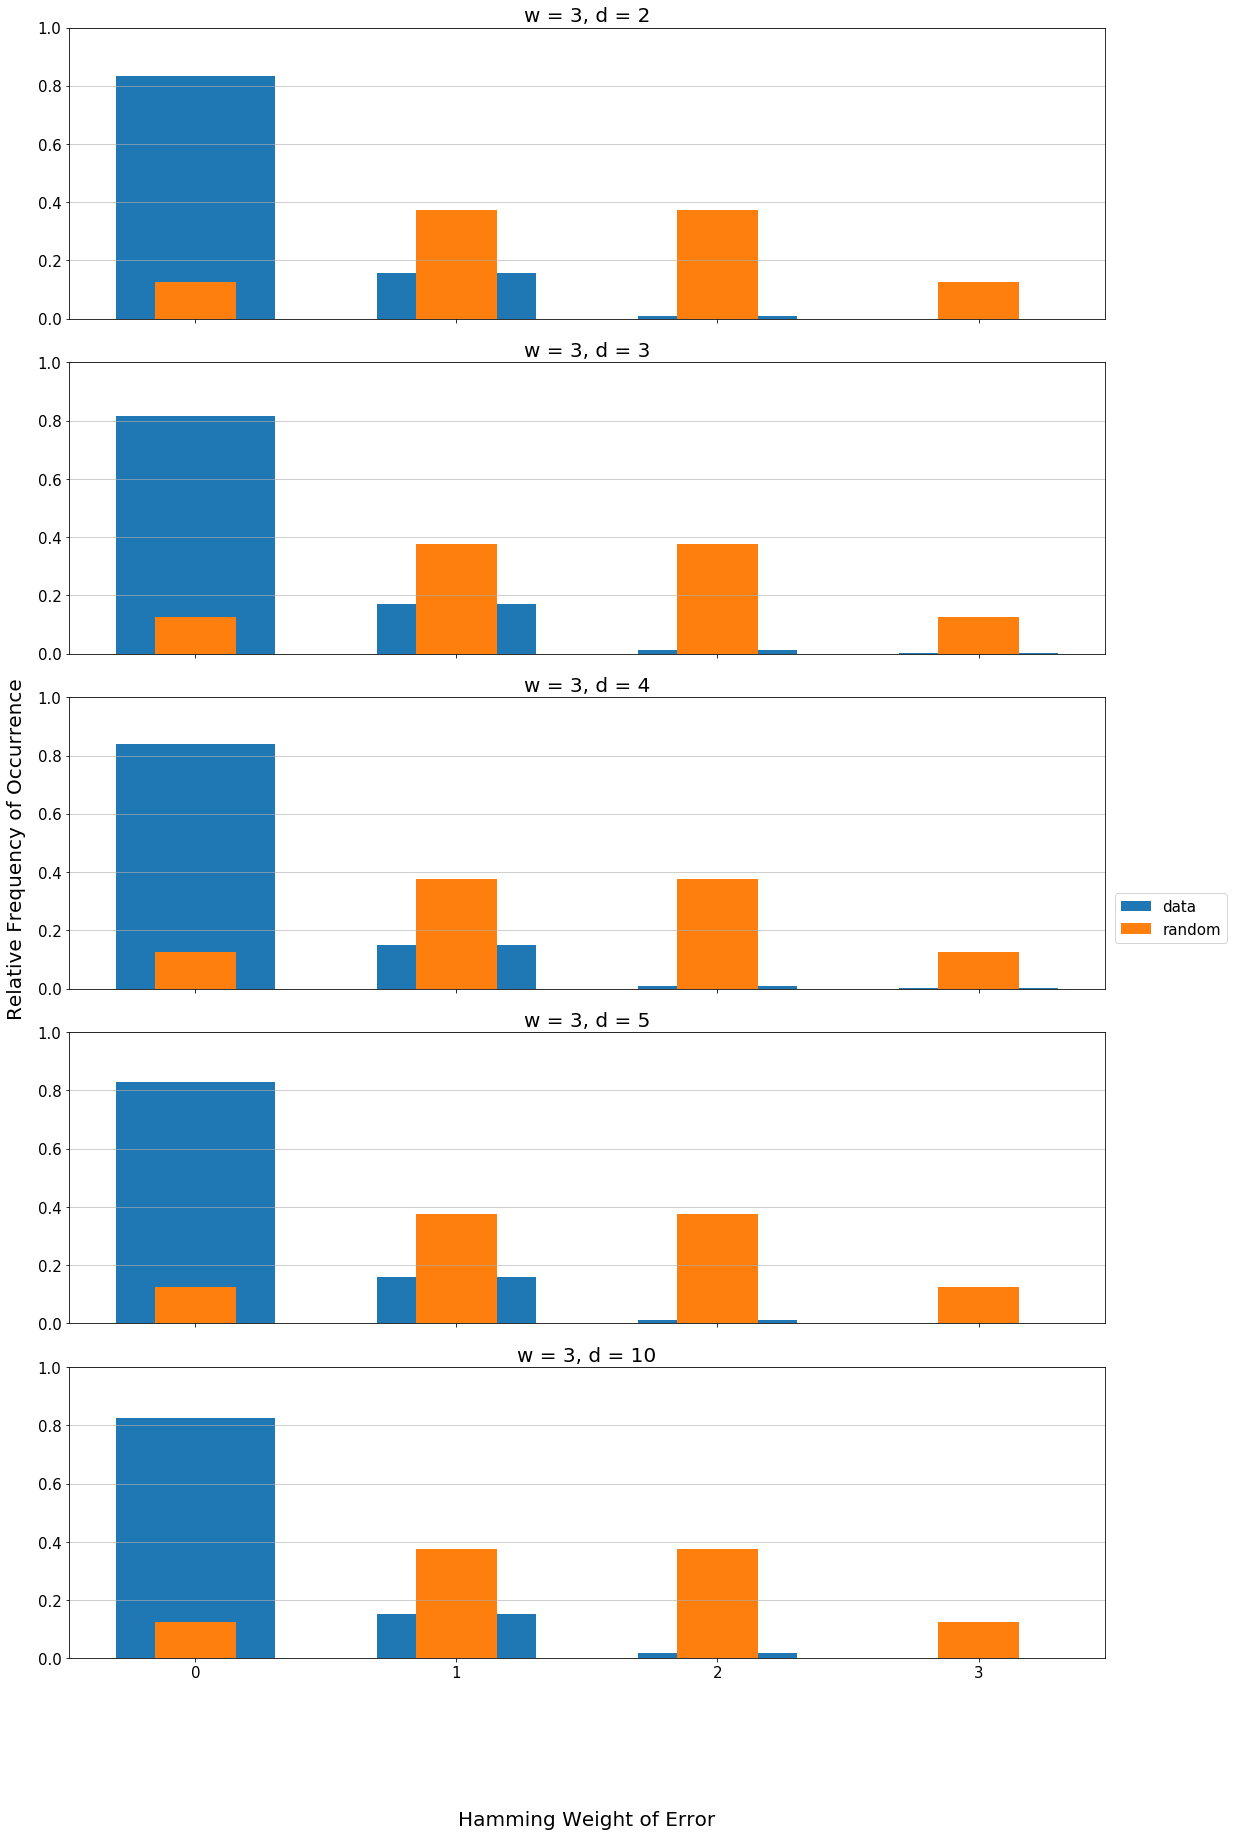

In [33]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=[w], plot_rand_distr=True)

### Plot all of the distributions

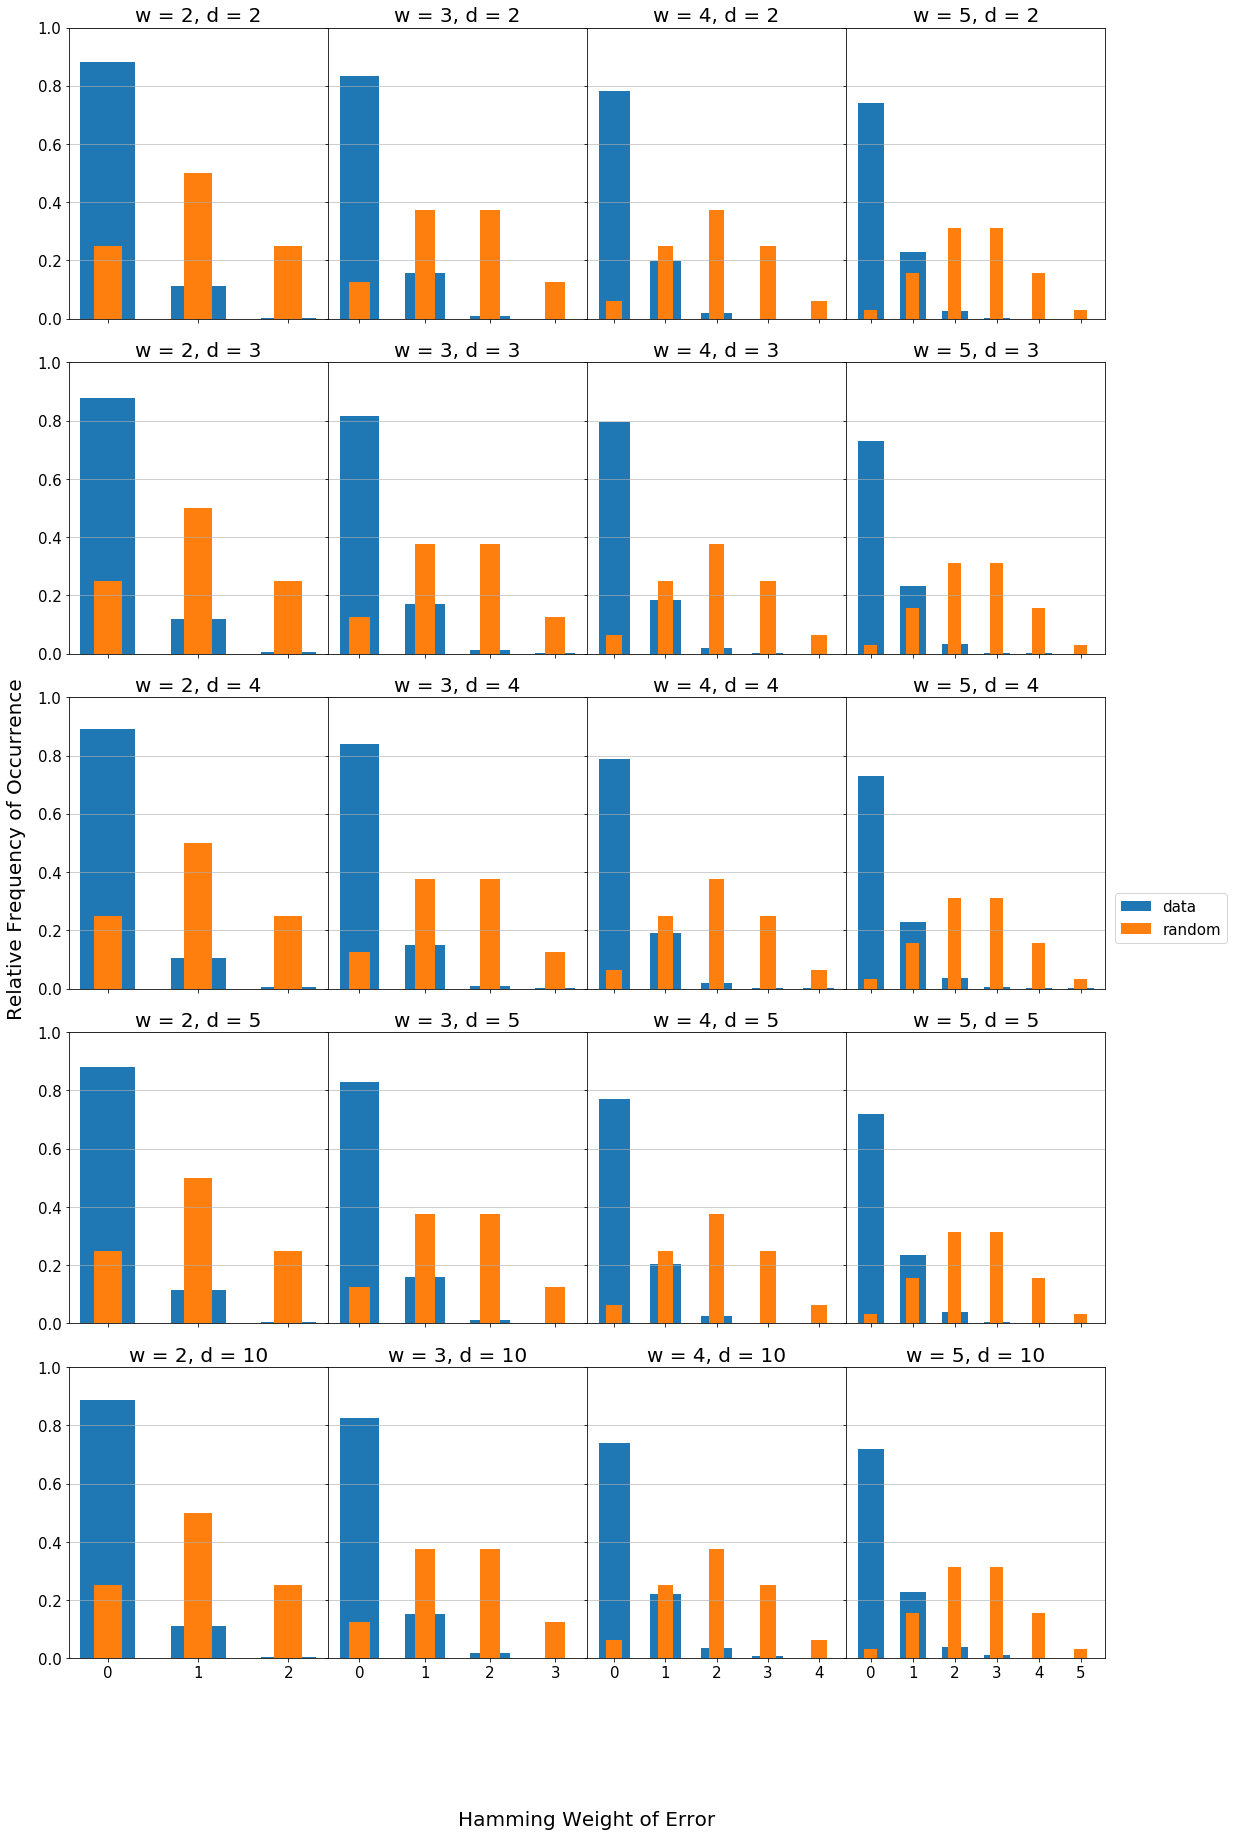

In [34]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=None, depths=None, plot_rand_distr=True)

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data.

In [35]:
# extract data from avg_err_hamm_distrs
widths = list(avg_err_hamm_distrs.keys())
depths = list(avg_err_hamm_distrs[widths[0]].keys())

avg_pr_succ_arr = {w: {d: distr[0] for d, distr in d_distrs.items()} for w, d_distrs in avg_err_hamm_distrs.items()}
# this is equivalently wrapped up in the following
assert avg_pr_succ_arr == average_distributions(get_single_target_success_probabilities(noisy_results, 
                                                                                        ideal_results))

# count as success even if there are log many bits incorrect.
avg_pr_succ_allow_log_errors = average_distributions(get_single_target_success_probabilities(noisy_results, 
                                                                                             ideal_results, 
                                                     allowed_errors = basement_log_function))

ideal_distrs = {w: [1] + [0 for _ in range(w)] for w in widths}
rand_distrs = {w: get_random_hamming_wt_distr(w) for w in widths}

pr_succ_rand = {w: 1/2**w for w in widths}
pr_succ_rand_allow_log_errors = {w: sum(rand_distrs[w][0:basement_log_function(w)+1]) for w in widths}

# total variation distance
tvd_noisy_ideal = {w: {d: get_total_variation_dist(distr, ideal_distrs[w]) for d, distr in d_distrs.items()}
                              for w, d_distrs in avg_err_hamm_distrs.items()}

# tvd_noisy_ideal is equivalent to 1 - success probability.
np.testing.assert_allclose([pr for d_vals in avg_pr_succ_arr.values() for pr in d_vals.values()], 
                           [1 - val for d_vals in tvd_noisy_ideal.values() for val in d_vals.values()])

tvd_noisy_rand = {w: {d: get_total_variation_dist(distr, rand_distrs[w]) for d, distr in d_distrs.items()}
                              for w, d_distrs in avg_err_hamm_distrs.items()}

print(avg_pr_succ_arr)
print(avg_pr_succ_allow_log_errors)
print(tvd_noisy_rand)

{2: {2: 0.8824000000000002, 3: 0.8760999999999999, 4: 0.8922999999999999, 5: 0.8821, 10: 0.8854}, 3: {2: 0.8328999999999999, 3: 0.8171999999999999, 4: 0.8407999999999998, 5: 0.8301999999999998, 10: 0.8265}, 4: {2: 0.7817999999999998, 3: 0.7962, 4: 0.7868, 5: 0.7691, 10: 0.7376999999999999}, 5: {2: 0.7399, 3: 0.7308000000000001, 4: 0.7299, 5: 0.7182, 10: 0.7196999999999999}}
{2: {2: 0.9963000000000001, 3: 0.9948999999999998, 4: 0.9956999999999999, 5: 0.9967999999999998, 10: 0.9947000000000001}, 3: {2: 0.9894999999999999, 3: 0.9870000000000001, 4: 0.9895000000000002, 5: 0.9879, 10: 0.9789999999999999}, 4: {2: 0.9991, 3: 0.9987999999999999, 4: 0.9978, 5: 0.9978999999999998, 10: 0.9921}, 5: {2: 0.9965000000000002, 3: 0.9964000000000001, 4: 0.9930999999999998, 5: 0.9933, 10: 0.9864000000000003}}
{2: {2: 0.6324000000000001, 3: 0.6260999999999999, 4: 0.6423, 5: 0.6320999999999999, 10: 0.6354}, 3: {2: 0.7079, 3: 0.6922, 4: 0.7157999999999999, 5: 0.7051999999999999, 10: 0.7015}, 4: {2: 0.719299

## Success probablity and success probablity including a small number of errors

Next we will plot the success probablity of a circuit with a certain width as a function of depth. 

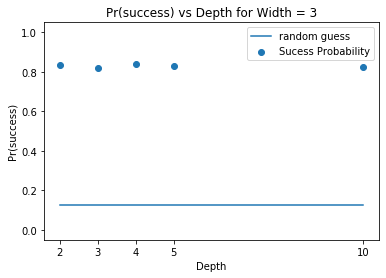

In [36]:
w=3
plt.scatter(depths, [avg_pr_succ_arr[w][d] for d in depths], label='Sucess Probability')
plt.plot(depths, [pr_succ_rand[w] for _ in depths], label='random guess')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(w))
plt.legend()
plt.show()

**Sucess if we allow for a small number of errors**

Some near term algorithms have robustness to noise. In light of that we might want to consider as successes answers that are only a little wrong.

To make this notion formal we allow a logarithmic number of bits to be flipped from the correct answer and call all such instances "success".

The logarithmic number of bits that we allow to flip is defined by the "basement" ${\mathcal B}$ of 

$\log_2 ({\rm number\ of\ bits})$

where the basement of a number is ${\mathcal B}(number) = 0$ if number$<=0$ and ${\mathcal B}(number) = {\rm floor (number)}$.


Supose we have a circuit of width 4 so that the correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4) = 2$.

So any string with hamming weight zero, one, or two counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

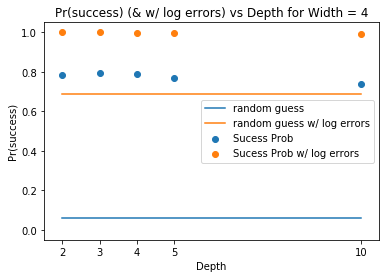

In [37]:
w=4
plt.scatter(depths, [avg_pr_succ_arr[w][d] for d in depths], label='Sucess Prob')
plt.plot(depths, [pr_succ_rand[w] for _ in depths], label='random guess')
plt.scatter(depths, [avg_pr_succ_allow_log_errors[w][d] for d in depths], label='Sucess Prob w/ log errors')
plt.plot(depths, [pr_succ_rand_allow_log_errors[w] for _ in depths], label='random guess w/ log errors')
plt.ylim([-0.05, 1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Pr(success)')
plt.title('Pr(success) (& w/ log errors) vs Depth for Width = {}'.format(w))
plt.legend()
plt.show()

## Total variation distance from ideal answer and random distribution

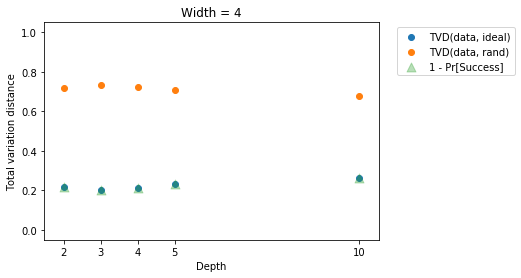

In [38]:
plt.figure()
plt.scatter(depths, [tvd_noisy_ideal[w][d] for d in depths], label='TVD(data, ideal)')
plt.scatter(depths, [tvd_noisy_rand[w][d] for d in depths], label='TVD(data, rand)')
plt.scatter(depths, 1-np.asarray([avg_pr_succ_arr[w][d] for d in depths]),
            label='1 - Pr[Success]', alpha=0.33, marker='^', s=80)
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Total variation distance')
plt.title('Width = {}'.format(w))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

## Plot success probablity landscape

This is just the success probablity as a function of depth and width.

In [39]:
X, Y = np.meshgrid(widths, depths)

In [40]:
Zdata = np.reshape([avg_pr_succ_arr[w][d] for d in depths for w in widths], X.shape)
Zrand = np.reshape([pr_succ_rand[w] for d in depths for w in widths], X.shape)

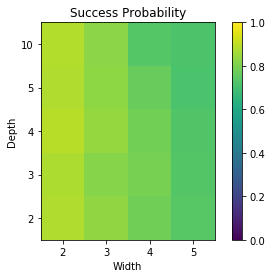

In [41]:
extent = -0.5, len(widths) - 0.5, -0.5, len(depths) - 0.5
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0, vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success Probability')
plt.show()

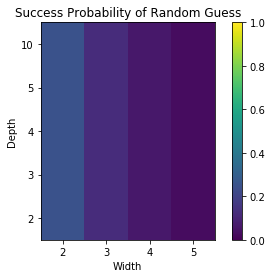

In [42]:
ax = plt.gca()
img = ax.imshow(Zrand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success Probability of Random Guess')
plt.show()

(<Figure size 288x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f777141a630>)

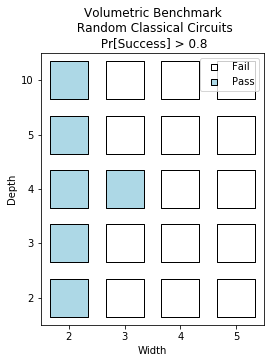

In [43]:
success_threshold = .8
ckt_success_probs = get_single_target_success_probabilities(noisy_results, ideal_results)
successes = determine_successes(ckt_success_probs, num_shots)
plot_success(successes, f"Volumetric Benchmark\n Random Classical Circuits\n Pr[Success] > {success_threshold}")

(<Figure size 360x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f77700a1780>)

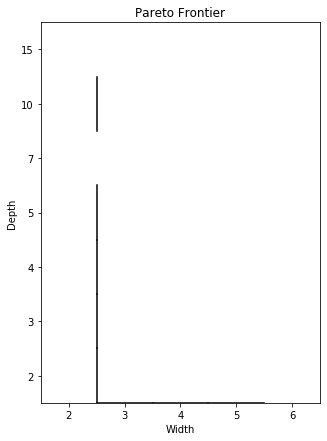

In [44]:
fake_successes = successes
plot_pareto_frontier(successes, 'Pareto Frontier', widths=[2,3,4,5,6], depths = [2,3,4,5,7,10,15])

## Plot total variation distance landscape

In [45]:
Ztvd_ideal = np.reshape([tvd_noisy_ideal[w][d] for d in depths for w in widths], X.shape)
Ztvd_rand = np.reshape([tvd_noisy_rand[w][d] for d in depths for w in widths], X.shape)

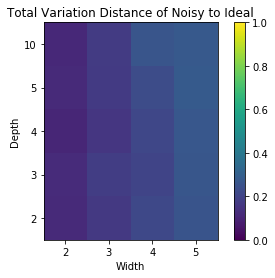

In [46]:
ax = plt.gca()
img = ax.imshow(Ztvd_ideal, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)


ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Total Variation Distance of Noisy to Ideal')
plt.show()

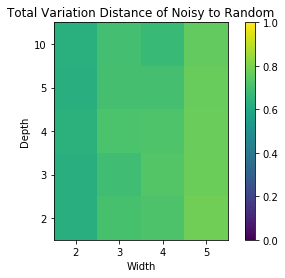

In [47]:
ax = plt.gca()
img = ax.imshow(Ztvd_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Total Variation Distance of Noisy to Random')
plt.show()

## Data exploration

In [48]:
from scipy.optimize import curve_fit

In [49]:
shape = Zdata.shape
size = Zdata.size
width_1d = X.reshape((1,size))
depth_1d = Y.reshape((1,size))
data_1d = Zdata.reshape((1,size))
print(data_1d.shape)
print(width_1d.shape)

(1, 20)
(1, 20)


In [50]:
dims = np.zeros_like(width_1d)
dims[0,0] = shape[0]
dims[0,1] = shape[1]

xdata = np.vstack((dims, width_1d, depth_1d))
xdata

array([[ 5,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 2,  3,  4,  5,  2,  3,  4,  5,  2,  3,  4,  5,  2,  3,  4,  5,
         2,  3,  4,  5],
       [ 2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,
        10, 10, 10, 10]])

### Fitting models

Two parameter model 


$f(W,D,p_W,p_D) =  (1-p_W)^W * (1-p_D)^D $

The fidelity is proporional to $1 - p$

In [51]:
def two_param(x, pw, pd):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = (1-pw)**(widths) * (1-pd)**depths
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

One parameter model

$f(W,D,p) =  (1-p)^{W * D} $

In [52]:
def one_param(x,p):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = (1-p)**(widths * depths)
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

Josh: "From my prior work a better model to fit to is "

Pcheck$(W,D,p,a,b,c) = \exp[ -(a p^2 + b p + c)* W*D] $


In [53]:
def two_param_exp(x,p,a,b):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = np.exp(-(a*p + b) * widths * depths)
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

**Start with one paramter model**

In [54]:
pguess = 0.1
popt, pcov = curve_fit(one_param, xdata, data_1d.ravel(), p0=pguess, bounds=(0, 1))

In [55]:
print('The estimated error is p = ', str(np.round(popt[0],4)))
print('The estimated product of the one and two qubit fidelity is F = ', str(1-np.round(popt[0],4)))
#print('The one standard deviation on the estimate is ', str(np.round(np.sqrt(np.diag(pcov)[0]),5)))

The estimated error is p =  0.0111
The estimated product of the one and two qubit fidelity is F =  0.9889


In [56]:
zfit = one_param(xdata, popt)
Z_fit = zfit.reshape(shape)

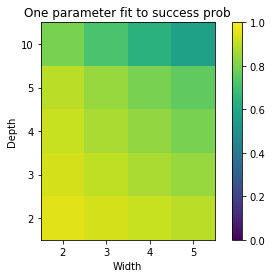

In [57]:
ax = plt.gca()
img = ax.imshow(Z_fit, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)


ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('One parameter fit to success prob')
plt.show()

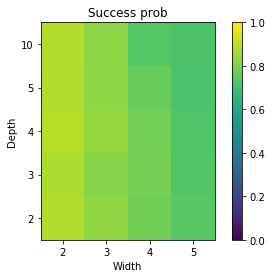

In [58]:
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)


ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success prob')
plt.show()

**Two parameter model**

In [59]:
# pguess2d_exp = [0.0276, 0.01, 0.4]
# popt2d, pcov2d = curve_fit(two_param_exp, xdata, data_1d.ravel(), p0=pguess2d, bounds=(0., 1))

In [60]:
popt2d, pcov2d = curve_fit(two_param, xdata, data_1d.ravel(), bounds=(0., 1))

In [61]:
popt2d

array([0.05929668, 0.00165794])

In [62]:
zfit2d = two_param(xdata, popt2d[0], popt2d[1])
Z_fit2d = zfit2d.reshape(shape)
print(Z_fit2d)

[[0.88199086 0.82969173 0.78049376 0.73421307]
 [0.88052857 0.82831615 0.77919975 0.73299579]
 [0.87906871 0.82694285 0.77790788 0.73178053]
 [0.87761126 0.82557182 0.77661815 0.73056728]
 [0.8703602  0.81875073 0.77020153 0.72453113]]


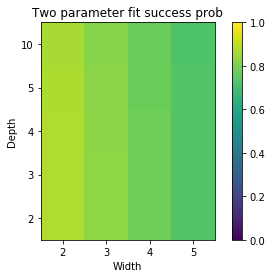

In [63]:
ax = plt.gca()
img = ax.imshow(Z_fit2d, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0, vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Two parameter fit success prob')
plt.show()

## Plot the distribution of sublattice widths

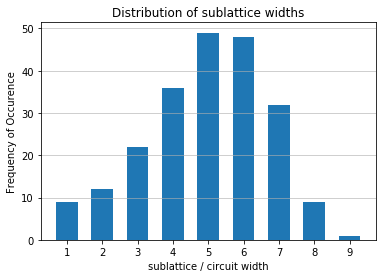

In [64]:
G = perfect_qc.qubit_topology()
len(perfect_qc.qubit_topology())
# distribution of graph lengths
distr = []
for num_nodes in range(1, len(G.nodes) + 1):
    listg = generate_connected_subgraphs(G, num_nodes)
    distr.append(len(listg))

cir_wid = list(range(1, len(G.nodes) + 1))
plt.bar(cir_wid, distr, width=0.61, align='center')
plt.xticks(cir_wid)
plt.xlabel('sublattice / circuit width')
plt.ylabel('Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of sublattice widths')
plt.show()